# Build a decision tree classifier to predict whether a customer will purchase a product or service based on their demographic and behavioral data. Use a dataset such as the Bank Marketing dataset from the UCI Machine Learning Repository.

In [4]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

bank_marketing = fetch_ucirepo(id=222)
X = bank_marketing.data.features.copy()  # Make a copy to avoid SettingWithCopyWarning
y = bank_marketing.data.targets['y'].map({'yes': 1, 'no': 0})  # Binary target

categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

In [5]:
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')) 
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'classifier__max_depth': [None, 5, 10, 15],  
    'classifier__min_samples_split': [2, 5, 10], 
    'classifier__min_samples_leaf': [1, 2, 4]    
}

In [7]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)  # Fit on original data, preprocessing is handled in the pipeline

best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

Best parameters: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2}


In [8]:
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy (Tuned Model): {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Accuracy (Tuned Model): 0.90
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      7952
           1       0.65      0.33      0.44      1091

    accuracy                           0.90      9043
   macro avg       0.78      0.65      0.69      9043
weighted avg       0.88      0.90      0.88      9043



In [9]:
# 6. Feature Importance (after One-Hot Encoding)
feature_names = numerical_cols.tolist() + list(best_model.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols))
importances = best_model.named_steps['classifier'].feature_importances_
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False)

print("Feature Importances:")
print(feature_importances)

Feature Importances:
                feature  importance
3              duration    0.569490
49     poutcome_success    0.299460
0                   age    0.049995
42            month_mar    0.039743
34          contact_nan    0.017572
43            month_may    0.006088
1               balance    0.003519
28           housing_no    0.003160
2           day_of_week    0.002220
20      marital_married    0.001791
41            month_jun    0.001624
44            month_nov    0.001518
29          housing_yes    0.001450
10        job_housemaid    0.001262
5                 pdays    0.001108
30              loan_no    0.000000
31             loan_yes    0.000000
32     contact_cellular    0.000000
33    contact_telephone    0.000000
35            month_apr    0.000000
46            month_sep    0.000000
36            month_aug    0.000000
45            month_oct    0.000000
38            month_feb    0.000000
39            month_jan    0.000000
40            month_jul    0.000000
48     

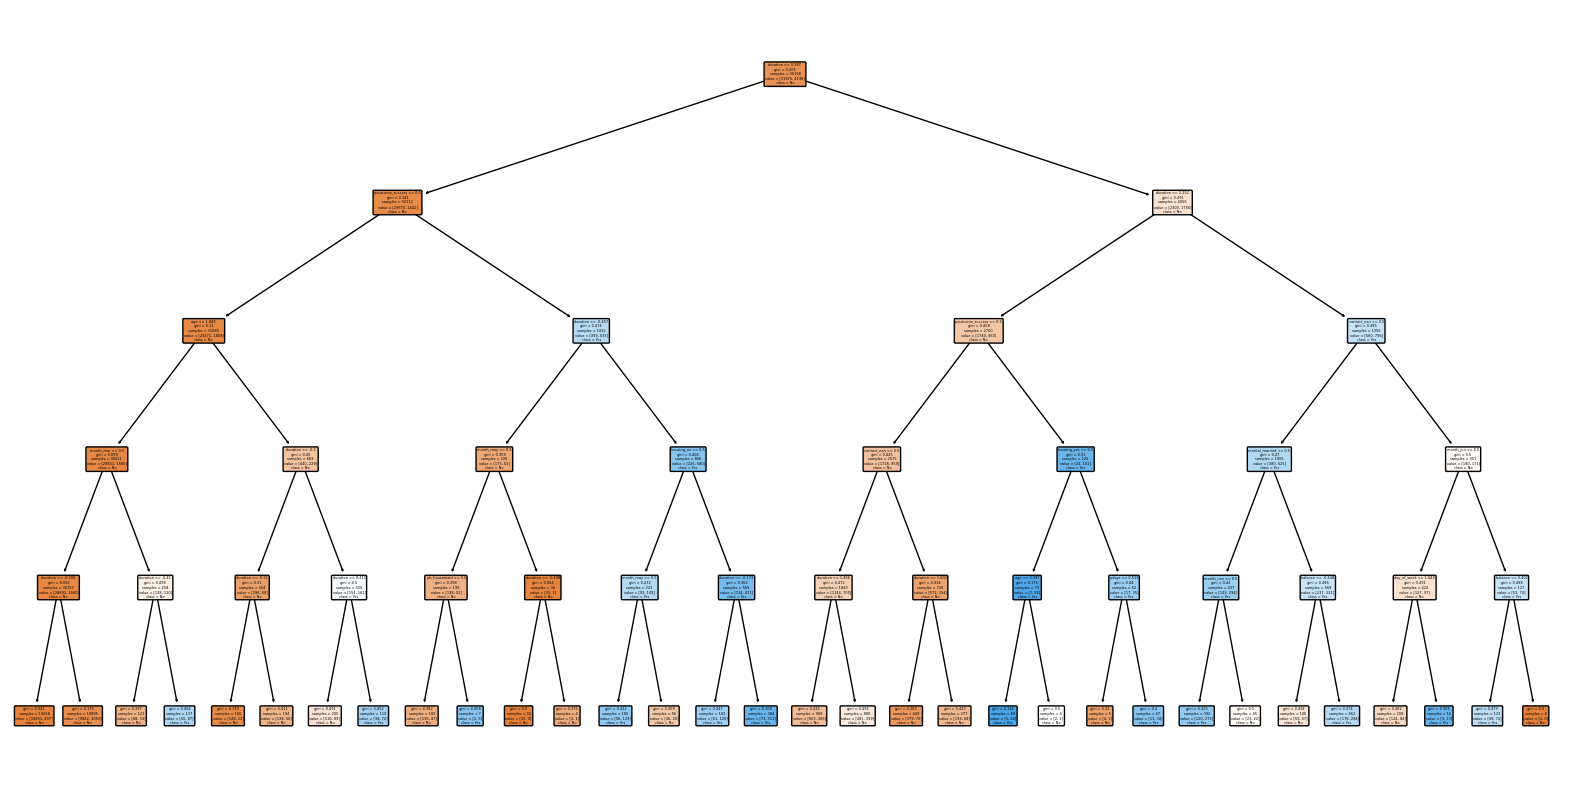

In [10]:
plt.figure(figsize=(20,10))
plot_tree(best_model.named_steps['classifier'], filled=True, feature_names=feature_names, class_names=['No', 'Yes'], rounded=True)
plt.show()
